In [13]:
########## organize thes summary files
import glob
import h5py

fnames = glob.glob('*/*/summ.hdf')

files = {}
for fname in fnames:
    net, time, _ = fname.split('/')
    time = int(time)
    
    if net not in files:
        files[net] = {}
        
    files[net][time] = fname        

In [14]:
# use instead stellar formation rate prior
from pycbc.cosmology import cosmological_quantity_from_redshift, redshift
from numpy.random import uniform
from scipy.stats import gaussian_kde
import pylab
import numpy

inj = h5py.File('./injection.hdf', 'r')
idist = inj['distance'][:]

# crude finite differencing is sufficient here

# stellar rate density from modified by cosmological time dilation
# https://arxiv.org/pdf/1403.0007.pdf
def stellar_rate(z):
    return 0.015 * (1 + z) ** 2.7 / (1 + ((1 + z) / 2.9) ** 5.6) / (1 + z)

z = redshift(idist)
cp = cosmological_quantity_from_redshift(redshift(idist + 0.01), 'comoving_volume')
cm = cosmological_quantity_from_redshift(redshift(idist - 0.01), 'comoving_volume')
w = (cp - cm) * stellar_rate(z)
w /= w.sum()


# Sets the assumed rate per volume
local_rate = 300
local_vol = cosmological_quantity_from_redshift(0.1, 'comoving_volume')
rate = local_vol / 1e9 * local_rate / w[redshift(idist) < 0.1].sum()
w *= rate

print(w.sum())

642253.1459483368


In [15]:
##### Oranize retrieval of summary data and allow for masking / subselection based on criteria (such as distance)
asizes = [0.1, 1, 10, 100, 1000, 44000]
alabel = ['A$_{90} <$ 0.1 deg$^2$', 
          'A$_{90} <$ 1 deg$^2$',
          'A$_{90} <$ 10 deg$^2$',
          'A$_{90} <$ 100 deg$^2$',
          'A$_{90} <$ 1000 deg$^2$',
          'All Sky']

def process(select):
    a90 = {}
    d90 = {}
    times = {}
    for net in files:
        for time in files[net]:
            fname = files[net][time]
            f = h5py.File(fname, 'r')

            snr = f['snr'][:]
            k = snr > 12

            if net not in times:
                times[net] = []
            times[net].append(time)

            if net not in a90:
                a90[net] = {}
            for s in asizes:
                if s not in a90[net]:
                    a90[net][s] = []
                
                ak =  f['a90'][:] < s
                #print(f['a90'][:].min())
                wf = w[k & ak & select]
                e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
                e = (len(wf) * e) ** 0.5
                a90_num = wf.sum() 
                
                
                ds = idist[k & ak & select]
                l = ds.argsort()
                ds = ds[l]
                wcount = wf[l].cumsum() / wf.sum()

                if len(wcount) < 2:
                    dmax = 0
                else:
                    lmax = numpy.searchsorted(wcount, 0.9)
                    dmax = ds[lmax]
                
                a90[net][s].append((a90_num, e, dmax)) 

    for k in a90:
        times[k] = numpy.array(times[k])
        l = times[k].argsort()
        times[k] = times[k][l]
        for k2 in asizes:
            a90[k][k2] = numpy.array(a90[k][k2])[l]
    return times, a90

642253.1459483368


<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
/home/ahnitz/projects/env3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipy

820.9161402503016


<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
/home/ahnitz/projects/env3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipy

117.73823530032081


<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
/home/ahnitz/projects/env3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipython-input-8-4c295848b1c8>:36: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
<ipy

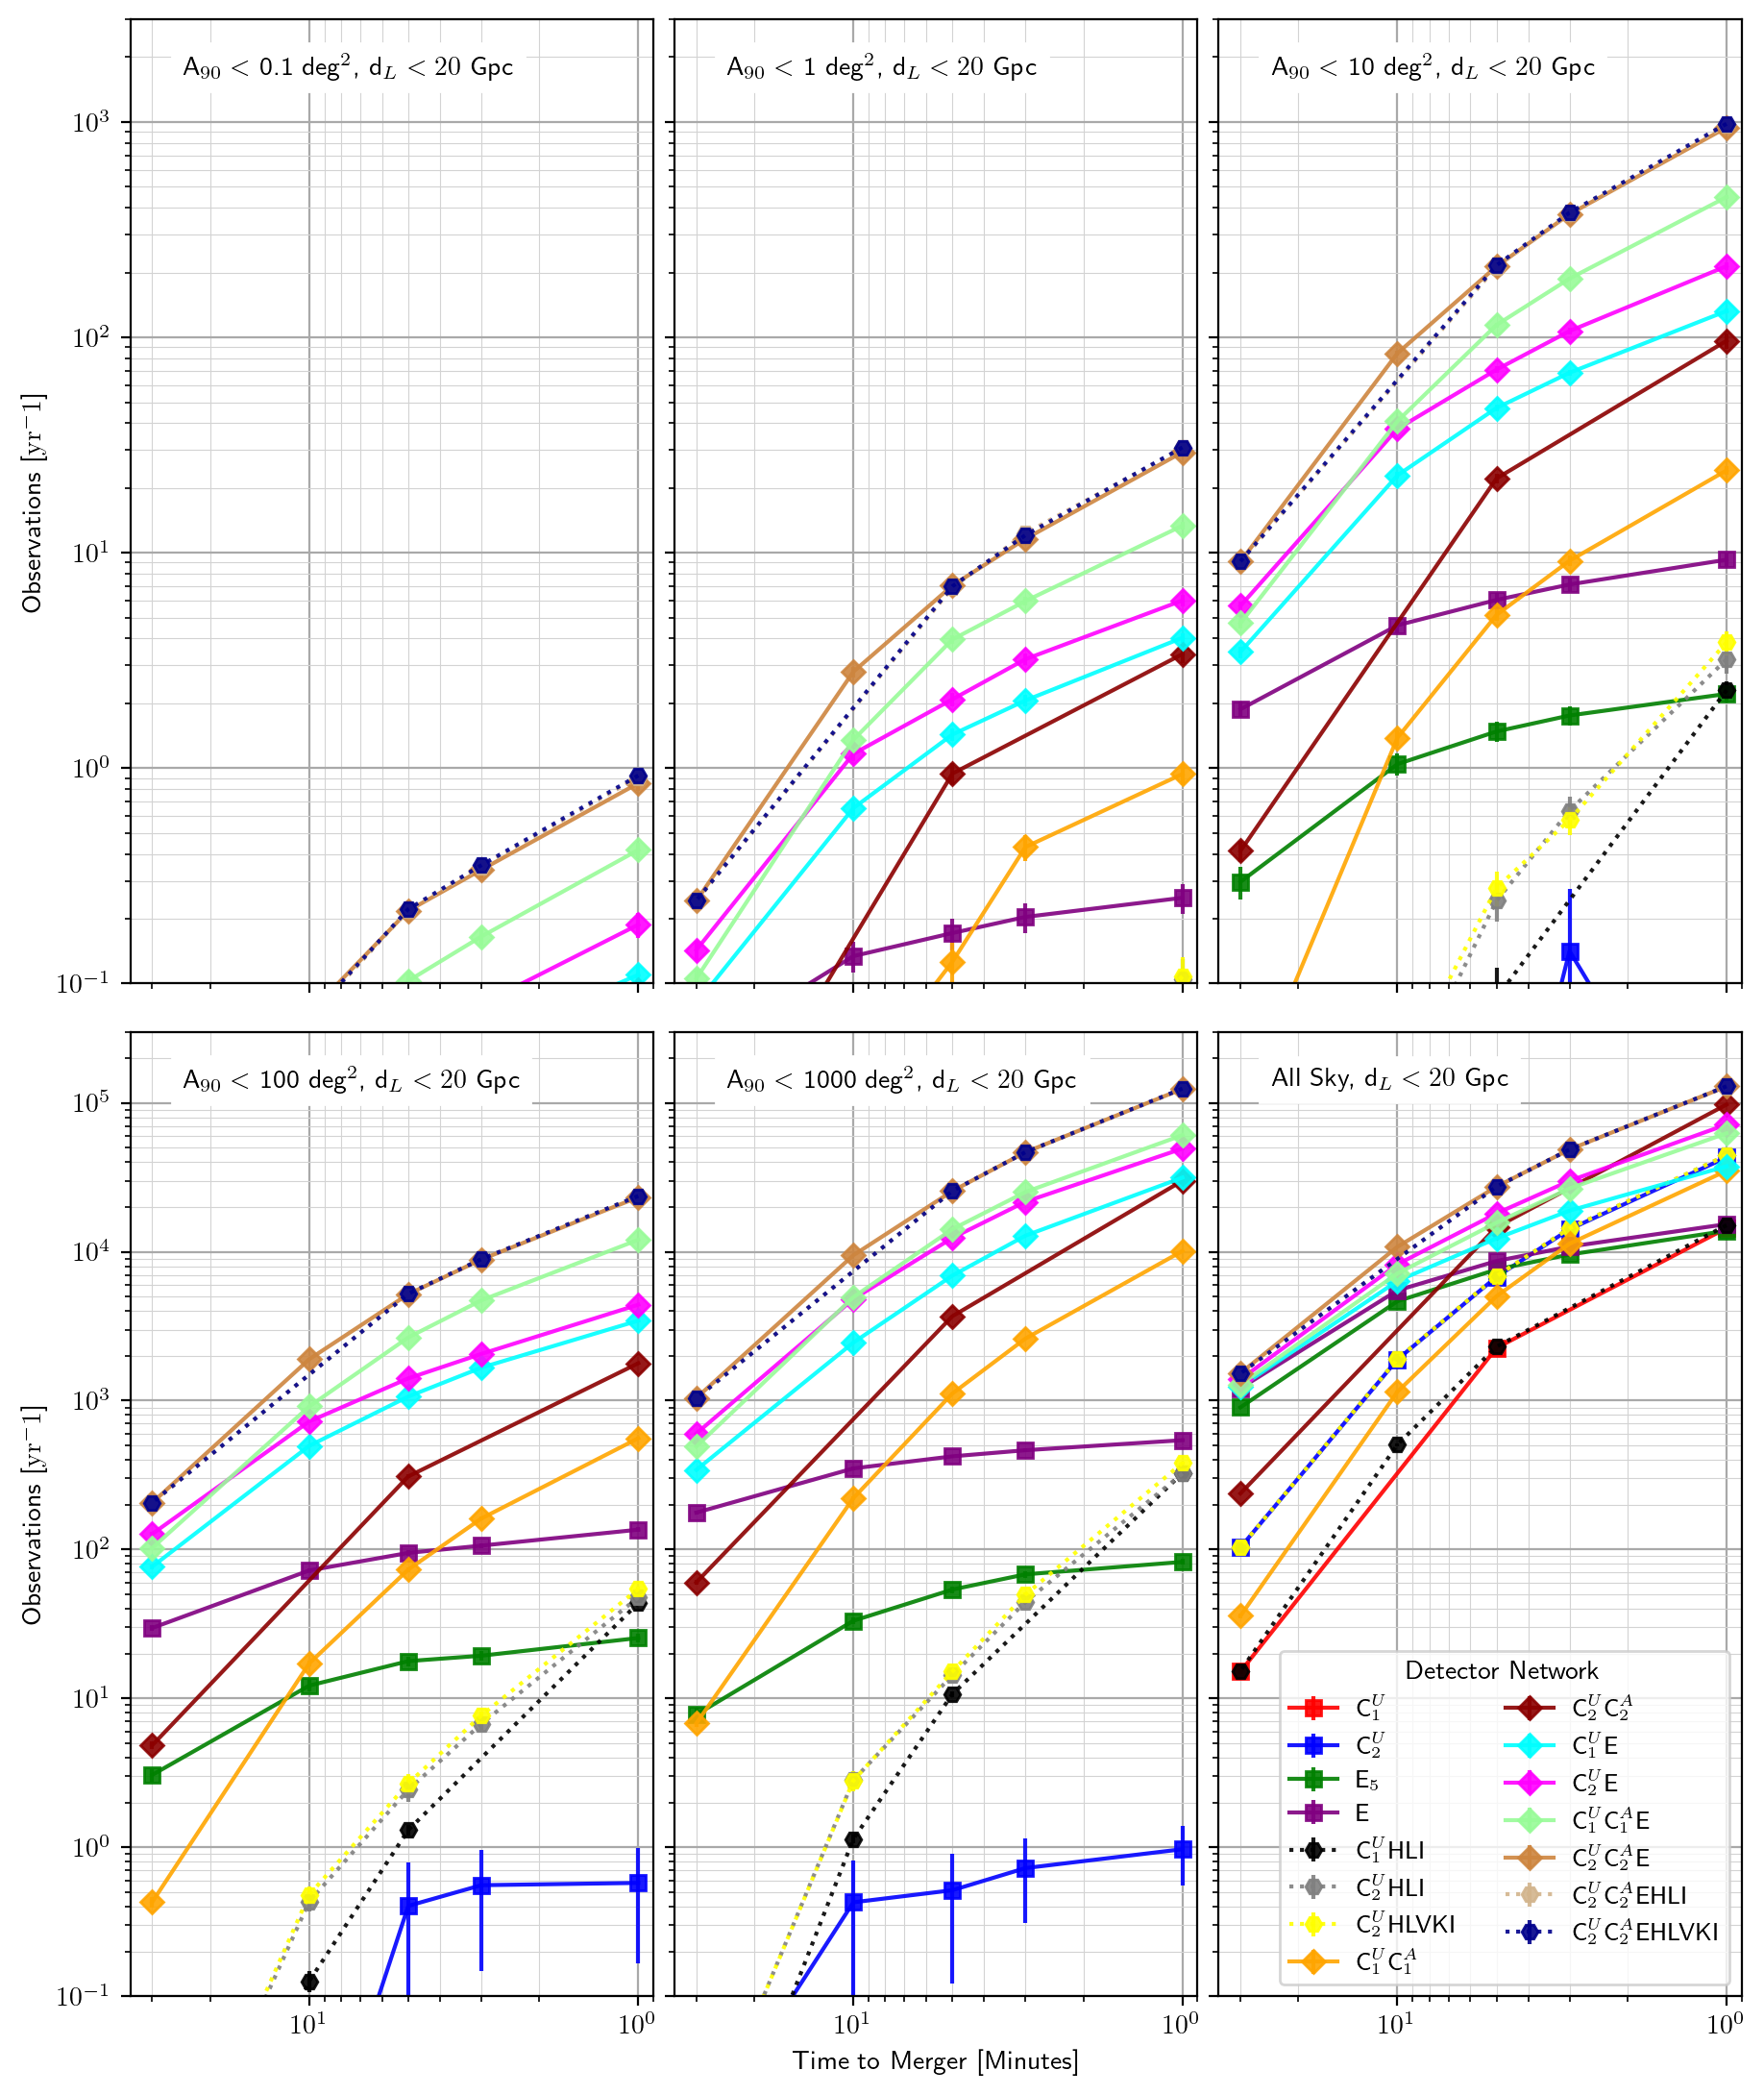

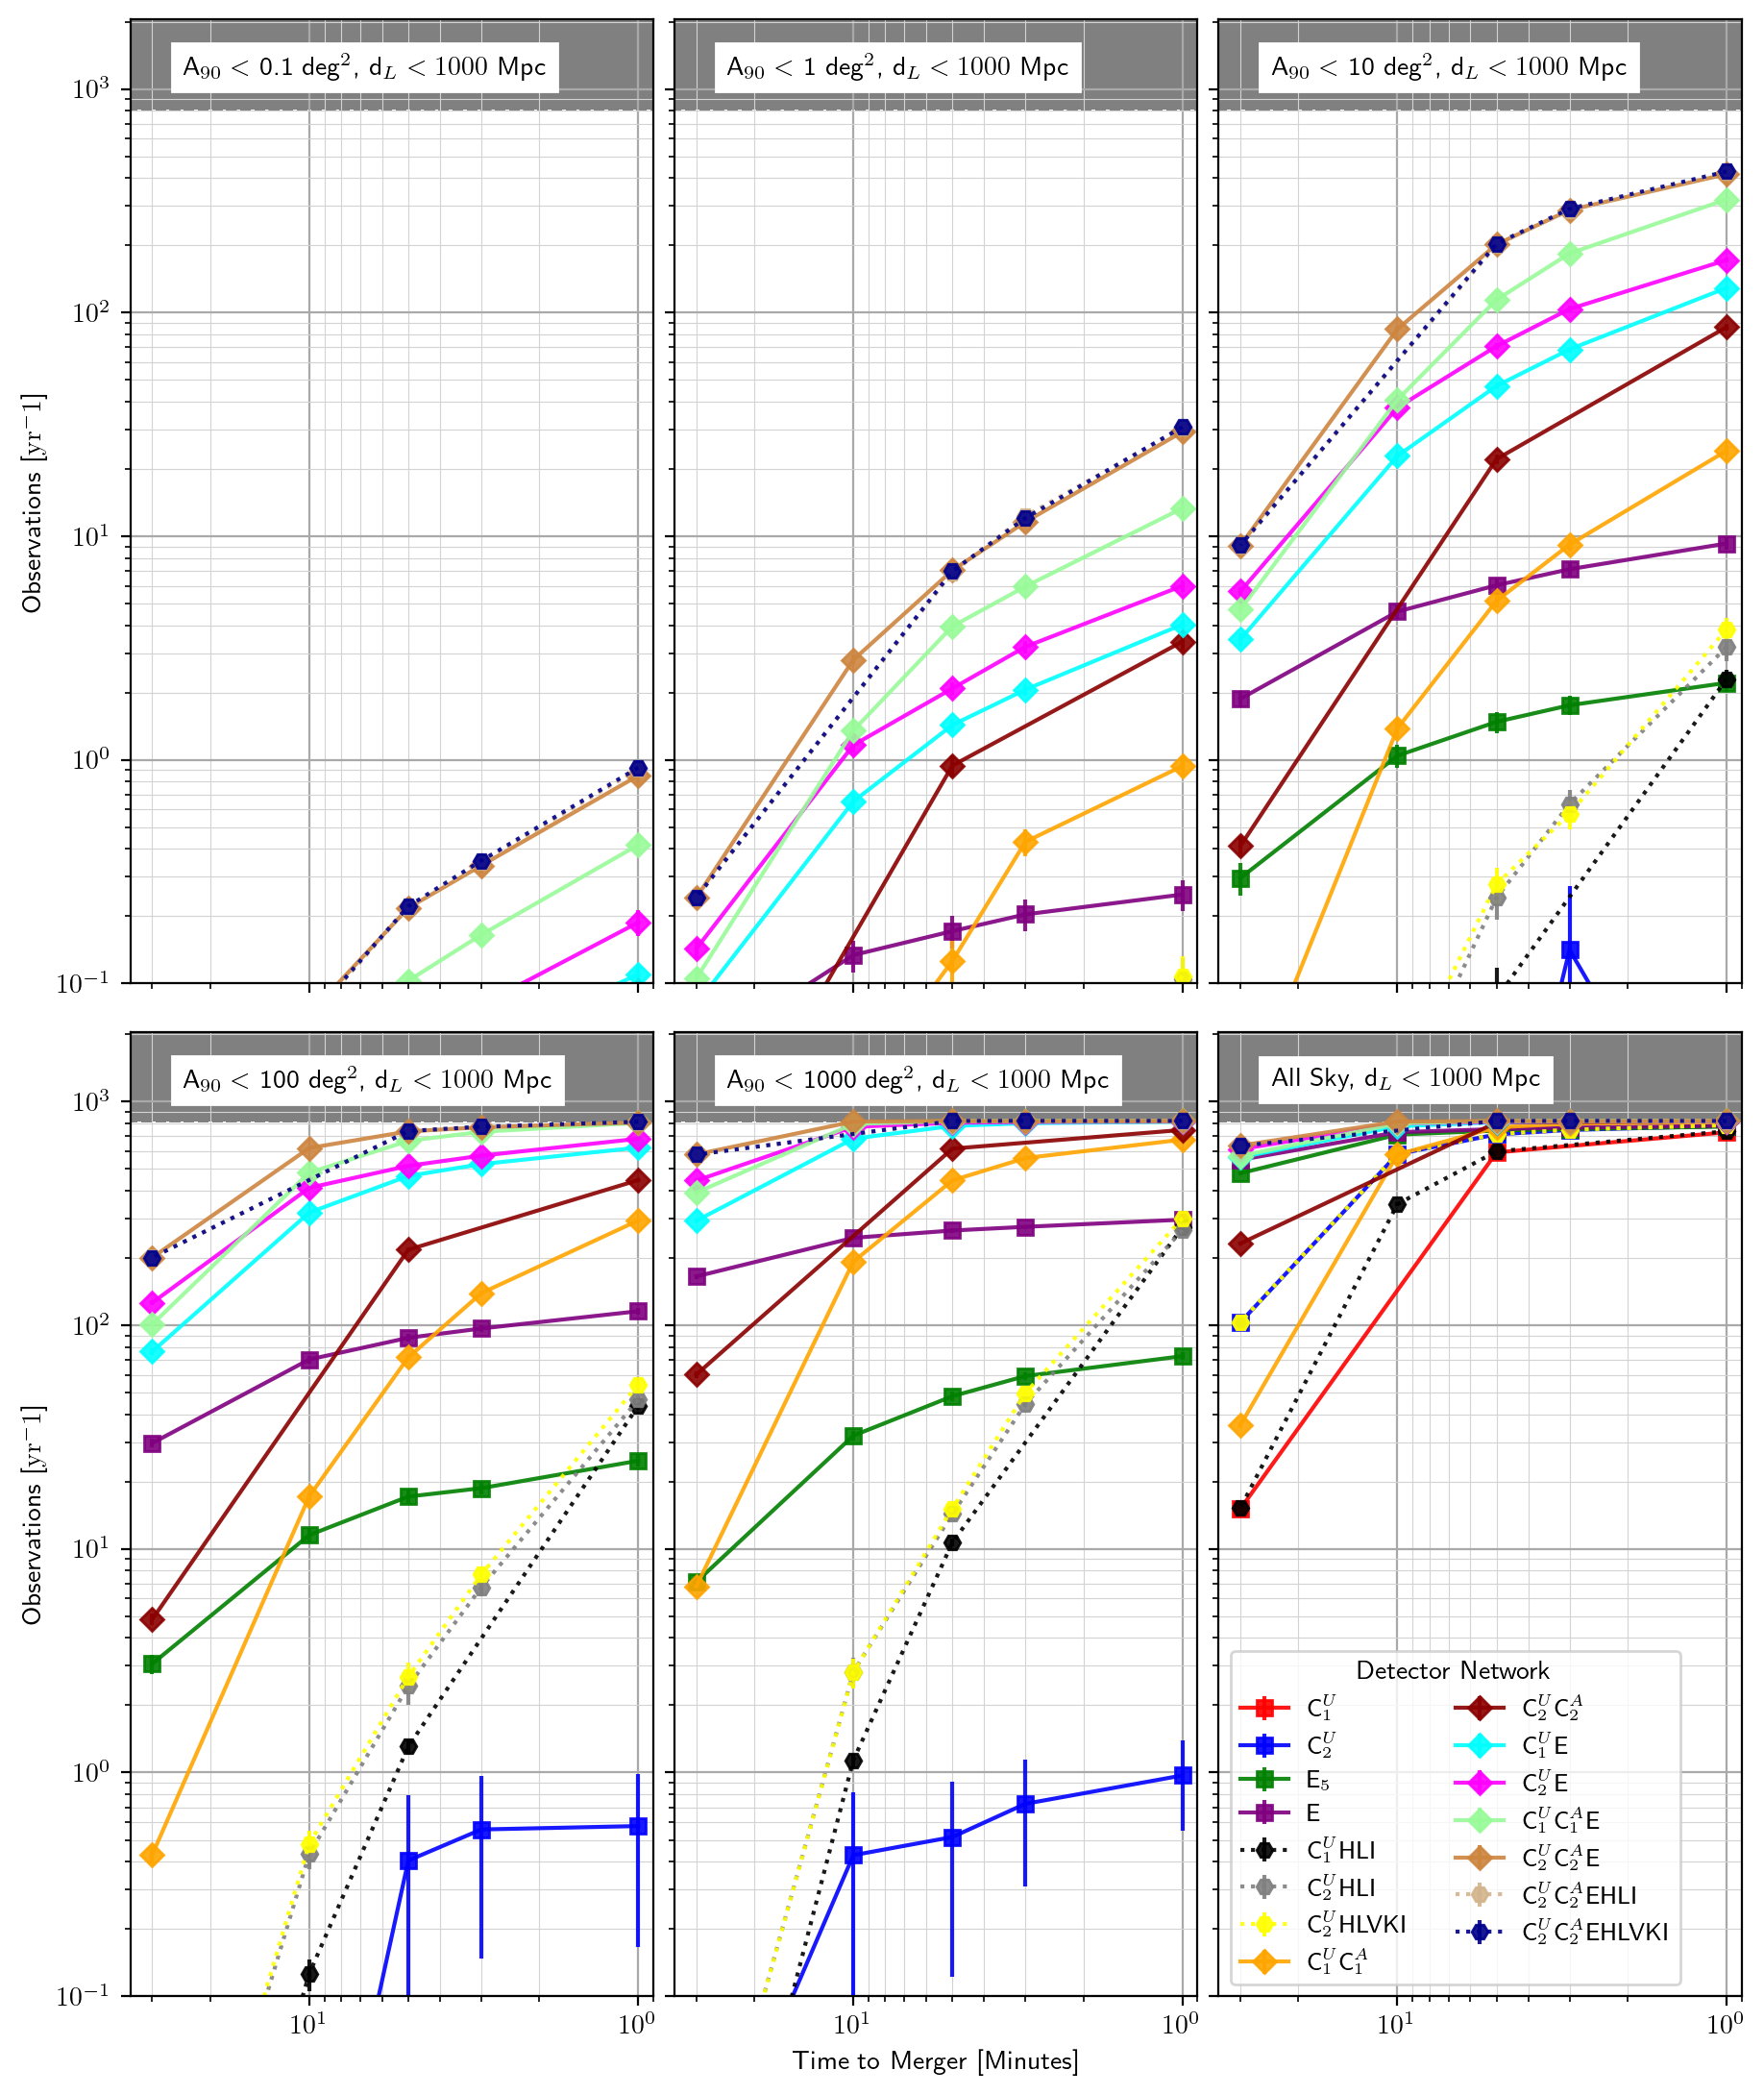

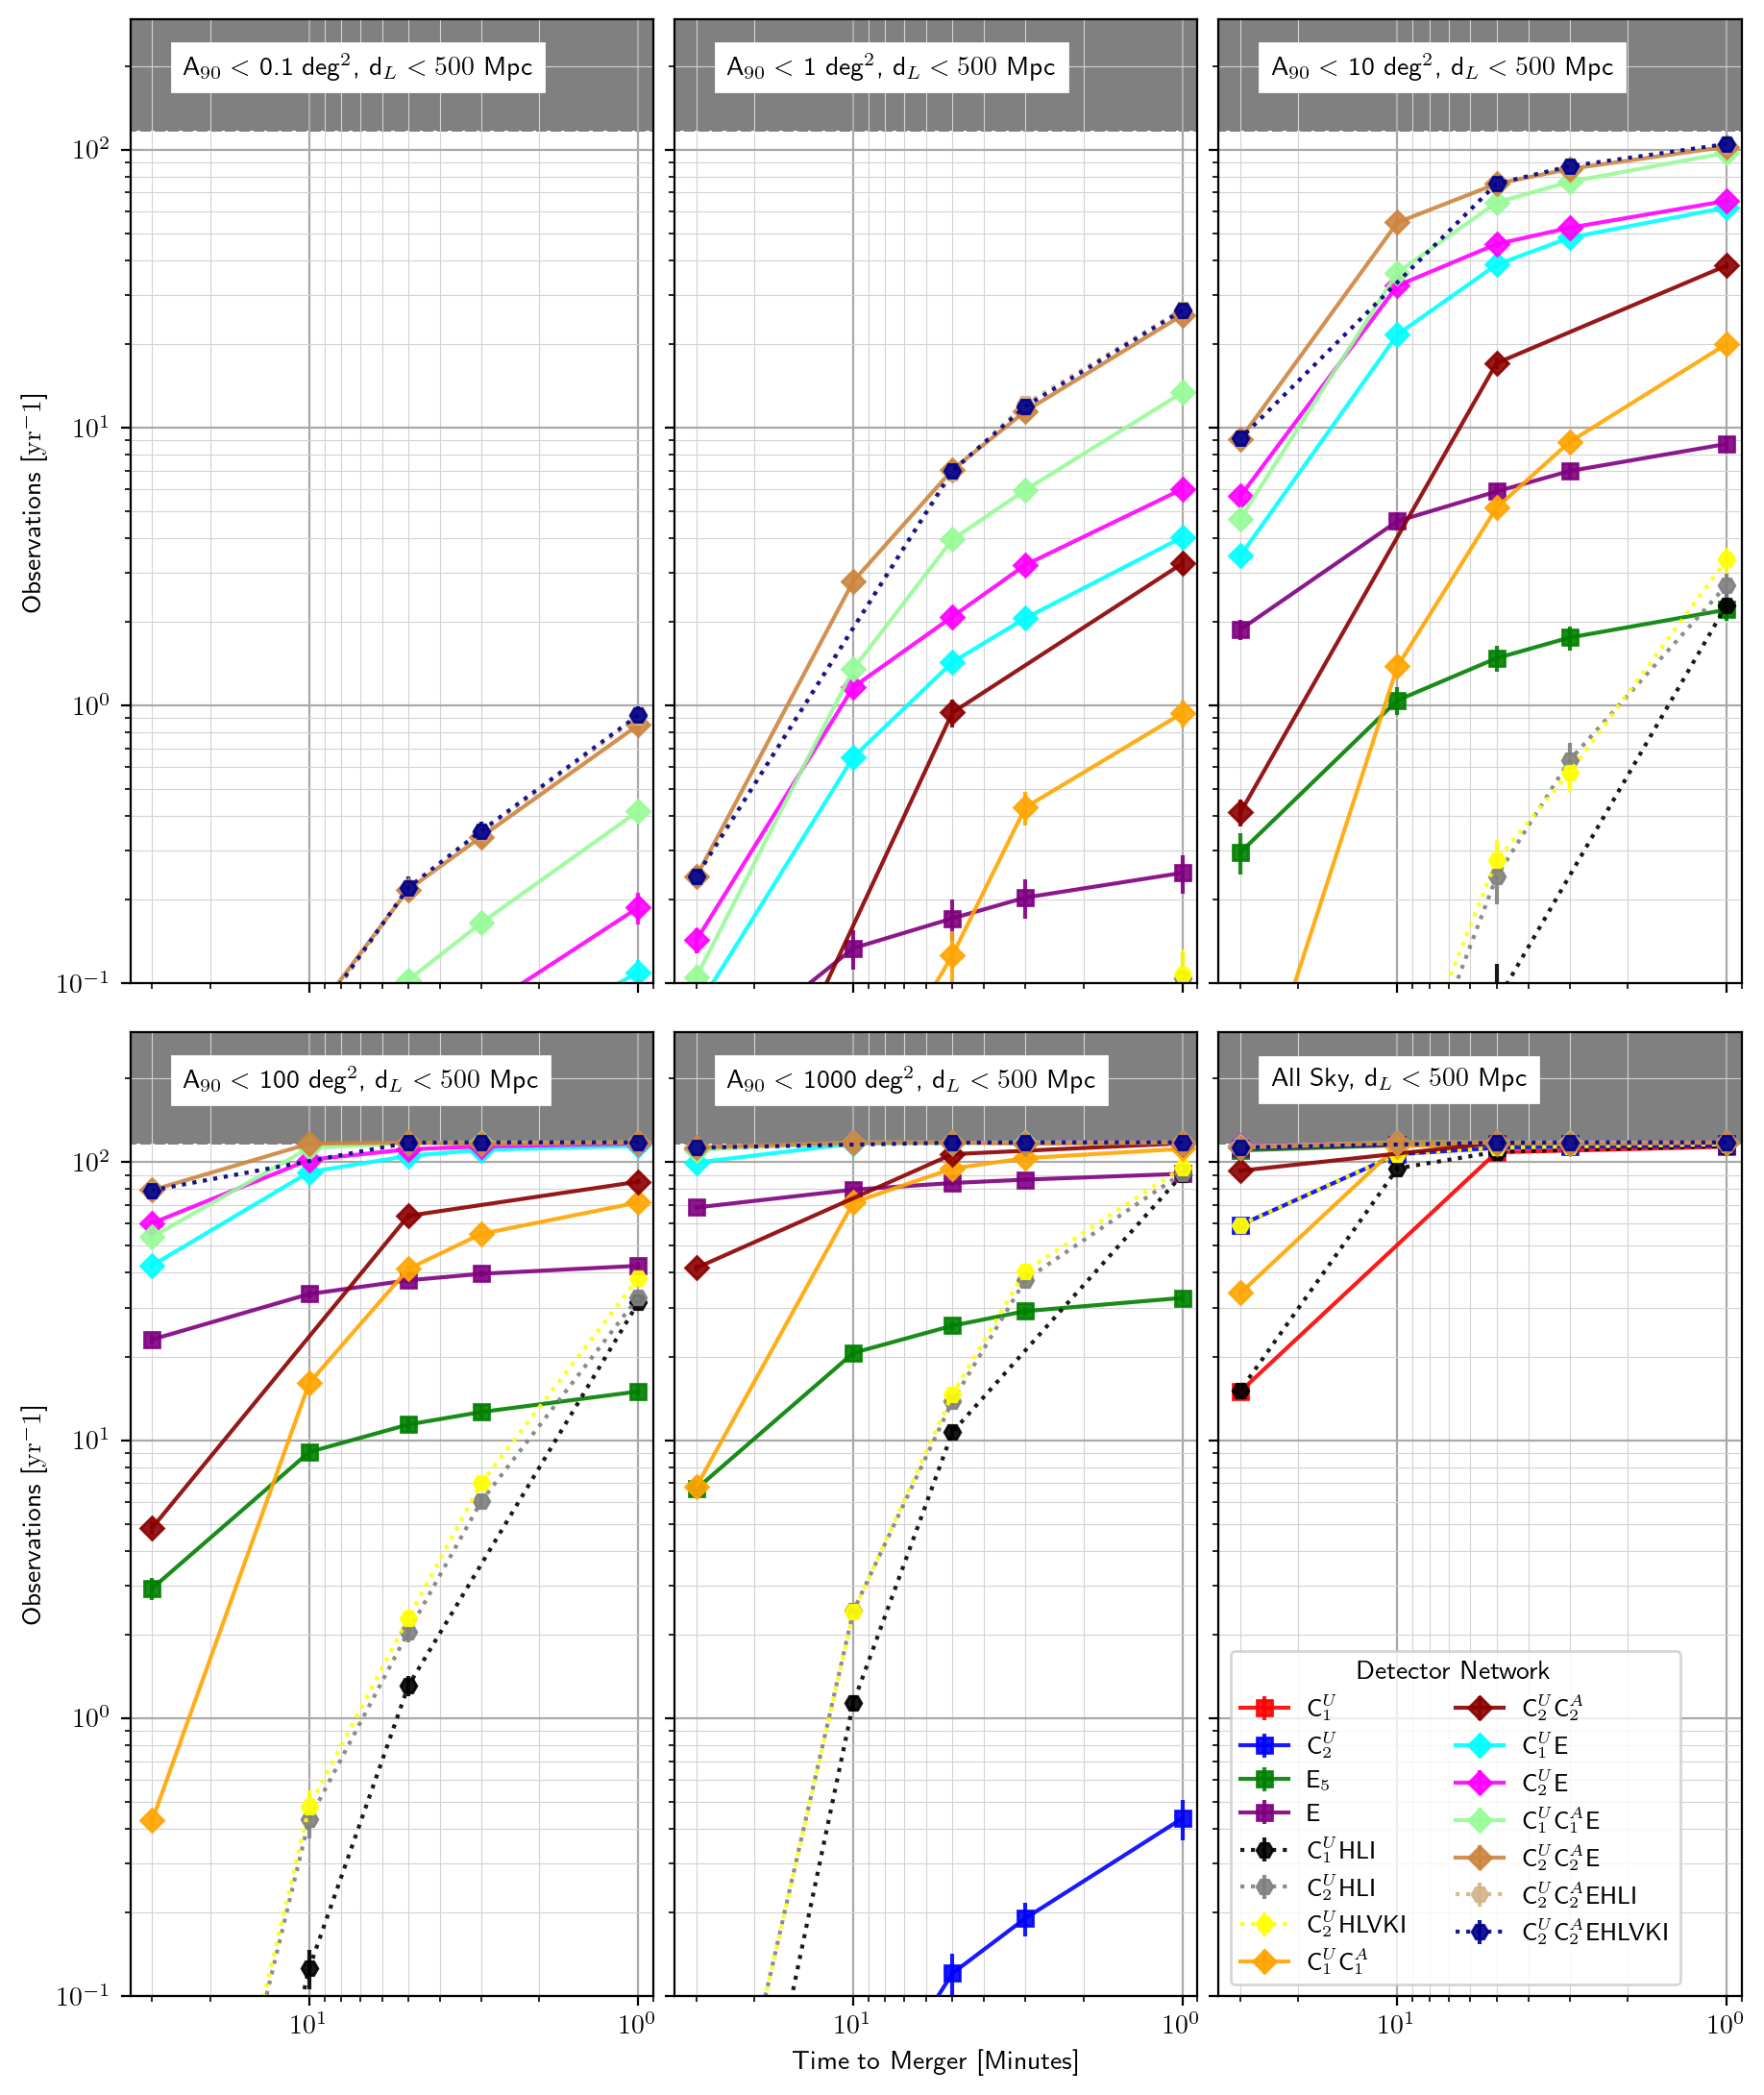

In [9]:
netname = {'CE1':("C$_{1}^U$", 'solid', 's', 'red'),
           'CE2':("C$_{2}^U$", 'solid', 's', 'blue'),
           'ET_5':("E$_{5}$", 'solid', 's', 'green'),
           'ET':('E', 'solid', 's', 'purple'),
           'CE1_LIGO':('C$_{1}^U$HLI', 'dotted', 'H', 'black'),
           'CE2_LIGO':('C$_{2}^U$HLI', 'dotted', 'H', 'grey'),
           'CE2_REST':("C$_{2}^U$HLVKI", 'dotted', 'H', 'yellow'),
           'CE1_CE1':('C$_{1}^U$C$_{1}^A$', 'solid', 'D', 'orange'),
           'CE2_CE2':('C$_{2}^U$C$_{2}^A$', 'solid', 'D', 'darkred'),
           'CE1_ET':("C$_{1}^U$E", 'solid', 'D', 'aqua'),
           'CE2_ET':("C$_{2}^U$E", 'solid', 'D', 'magenta'),
           'CE1_CE1_ET':("C$_{1}^U$C$_{1}^A$E", 'solid', 'D', 'palegreen'),
           'CE2_CE2_ET':("C$_{2}^U$C$_{2}^A$E", 'solid', 'D', 'peru'),
           'ligo_3g':('C$_{2}^U$C$_{2}^A$EHLI', 'dotted', 'H', 'tan'),
           'all':('C$_{2}^U$C$_{2}^A$EHLVKI', 'dotted', 'H', 'darkblue'),
          }

pylab.rc('text', usetex=True)
for dlimit in [20000, 1000, 500]:
    f, axs = pylab.subplots(2, 3, figsize=[9.5, 11], dpi=200, sharex=True, sharey='row')

    #total = cosmological_quantity_from_redshift(redshift(dlimit), 'comoving_volume')
    #rate = total / 1e9 * 300
    rate = w[idist < dlimit].sum()
    print(rate)
    
    for j, (s, aname) in enumerate(zip(asizes, alabel)):
        ps = []
        ls = []

        pylab.sca(axs[j // 3][j % 3])

        if dlimit < 20000:
            paname = aname + ', d$_L < {}$ Mpc'.format(dlimit)
        else:
            paname = aname + ', d$_L < 20$ Gpc'.format(dlimit)
        
        pylab.text(0.1, 0.95, paname,
         horizontalalignment='left',
         verticalalignment='center',
         backgroundcolor='white',
         transform = pylab.gca().transAxes)

        select = idist < dlimit
        times, a90 = process(select)
        for i, net in enumerate(list(netname.keys())):
                label = net if j == 0 else None

                if net in netname:
                    label, lstyle, marker, color = netname[net]

                val = a90[net][s][:,0]
                e = a90[net][s][:,1]

                pylab.axhspan(rate, 1e6, linestyle='--', linewidth=1, color='grey')
                l = pylab.errorbar(times[net] / 60.0, val, yerr=e, marker=marker,
                                label=label, c=color, linestyle=lstyle, alpha=0.9)      

        if j == 5:
            pylab.legend(title='Detector Network', ncol=2, fontsize=9)

        pylab.yscale('log')
        pylab.xscale('log')
        pylab.xlim(xmin=35, xmax=0.9)

        if j >= 3:
            pylab.ylim(ymin=0.1, ymax=3e5 if rate > 1e5 else rate * 2.5)
        else:
            pylab.ylim(ymin=0.1, ymax=3e3 if rate > 1e3 else rate * 2.5)

        pylab.grid(which='major', color='darkgray')
        pylab.grid(which='minor', linewidth=0.4, color='lightgray')

        if j == 0 or j == 3:
            pylab.ylabel('Observations [$\\textrm{yr}^-1$]', fontsize=10)
        if j == 4:
            pylab.xlabel('Time to Merger [Minutes]', fontsize=10)

    pylab.tight_layout()
    pylab.subplots_adjust(wspace=.04, hspace=.05)
    pylab.savefig('area-{}.pdf'.format(dlimit))

In [16]:
for i, net in enumerate(list(netname.keys())):
    for j, (s, aname) in enumerate(zip(asizes, alabel)):
        for dlimit in [20000, 1000, 500]:
            select = idist < dlimit
            times, a90 = process(select)

            label = net if j == 0 else None

            if net in netname:
                label, lstyle, marker, color = netname[net]

            val = a90[net][s][:,0]
            e = a90[net][s][:,1]

            print(net, s, dlimit, times[net], val)

<ipython-input-15-e1fd3d26fe1b>:35: RuntimeWarning: invalid value encountered in double_scalars
  e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)


CE1 0.1 20000 [  60  300 1800] [0. 0. 0.]
CE1 0.1 1000 [  60  300 1800] [0. 0. 0.]
CE1 0.1 500 [  60  300 1800] [0. 0. 0.]
CE1 1 20000 [  60  300 1800] [2.82844350e-05 3.57798562e-05 8.51313569e-06]
CE1 1 1000 [  60  300 1800] [2.82844350e-05 3.57798562e-05 8.51313569e-06]
CE1 1 500 [  60  300 1800] [2.82844350e-05 3.57798562e-05 8.51313569e-06]
CE1 10 20000 [  60  300 1800] [0.0004543  0.00052062 0.00043387]
CE1 10 1000 [  60  300 1800] [0.0004543  0.00052062 0.00043387]
CE1 10 500 [  60  300 1800] [0.0004543  0.00052062 0.00043387]
CE1 100 20000 [  60  300 1800] [0.00416284 0.00187986 0.00104032]
CE1 100 1000 [  60  300 1800] [0.00416284 0.00187986 0.00104032]
CE1 100 500 [  60  300 1800] [0.00416284 0.00187986 0.00104032]
CE1 1000 20000 [  60  300 1800] [0.05985277 0.01662131 0.0016967 ]
CE1 1000 1000 [  60  300 1800] [0.05985277 0.01662131 0.0016967 ]
CE1 1000 500 [  60  300 1800] [0.05985277 0.01662131 0.0016967 ]
CE1 44000 20000 [  60  300 1800] [14400.94902625  2259.05027925    

CE1_LIGO 44000 1000 [  60  300  600 1800] [736.77514487 599.42837978 348.20179005  15.26615411]
CE1_LIGO 44000 500 [  60  300  600 1800] [114.25798094 108.91671733  95.02163003  15.13233535]
CE2_LIGO 0.1 20000 [  60  180  300  600 1800] [0.00256289 0.00118697 0.00113635 0.         0.        ]
CE2_LIGO 0.1 1000 [  60  180  300  600 1800] [0.00256289 0.00118697 0.00113635 0.         0.        ]
CE2_LIGO 0.1 500 [  60  180  300  600 1800] [0.00256289 0.00118697 0.00113635 0.         0.        ]
CE2_LIGO 1 20000 [  60  180  300  600 1800] [1.04700305e-01 2.10732575e-02 3.21973120e-03 1.54349758e-03
 8.27529920e-06]
CE2_LIGO 1 1000 [  60  180  300  600 1800] [1.04700305e-01 2.10732575e-02 3.21973120e-03 1.54349758e-03
 8.27529920e-06]
CE2_LIGO 1 500 [  60  180  300  600 1800] [1.04700305e-01 2.10732575e-02 3.21973120e-03 1.54349758e-03
 8.27529920e-06]
CE2_LIGO 10 20000 [  60  180  300  600 1800] [3.19674290e+00 6.35165191e-01 2.42488612e-01 2.77266790e-02
 7.15546990e-04]
CE2_LIGO 10 1000 

CE1_ET 1 500 [  60  180  300  600 1800] [4.03315561 2.06275639 1.43319445 0.65260435 0.08080618]
CE1_ET 10 20000 [  60  180  300  600 1800] [132.58141928  68.53675471  47.02801056  22.88628358   3.46373008]
CE1_ET 10 1000 [  60  180  300  600 1800] [129.10647282  68.53675471  47.02801056  22.88628358   3.46373008]
CE1_ET 10 500 [  60  180  300  600 1800] [61.89588069 48.18764691 38.55152455 21.61154698  3.46373008]
CE1_ET 100 20000 [  60  180  300  600 1800] [3447.525928   1665.32892966 1064.98188014  496.88822069   76.71623744]
CE1_ET 100 1000 [  60  180  300  600 1800] [622.95243986 525.57506125 465.24667706 319.11554057  76.26271965]
CE1_ET 100 500 [  60  180  300  600 1800] [114.56915763 110.6725206  105.36531855  92.0971607   42.54165597]
CE1_ET 1000 20000 [  60  180  300  600 1800] [31475.37234781 12819.72263513  6915.4010939   2453.00261448
   342.72176001]
CE1_ET 1000 1000 [  60  180  300  600 1800] [813.81462866 800.83159598 778.63616846 682.92754296 293.13567782]
CE1_ET 1000 

ligo_3g 100 20000 [  60  180  300 1800] [23549.25865128  8928.98470544  5213.31037225   206.32458614]
ligo_3g 100 1000 [  60  180  300 1800] [808.06856262 772.58831778 737.72612459 201.11499774]
ligo_3g 100 500 [  60  180  300 1800] [117.2140345  117.57294901 117.61060437  79.42566999]
ligo_3g 1000 20000 [  60  180  300 1800] [123928.70845043  46640.44190092  25608.14830285   1036.90010849]
ligo_3g 1000 1000 [  60  180  300 1800] [816.01998185 820.03347404 819.14281053 580.98757213]
ligo_3g 1000 500 [  60  180  300 1800] [117.2140345  117.57294901 117.61060437 113.06841776]
ligo_3g 44000 20000 [  60  180  300 1800] [128376.56712506  48655.21903764  27378.84971062   1525.91927571]
ligo_3g 44000 1000 [  60  180  300 1800] [816.01998185 820.03347404 819.14281053 636.48912554]
ligo_3g 44000 500 [  60  180  300 1800] [117.2140345  117.57294901 117.61060437 113.26609061]
all 0.1 20000 [  60  180  300 1800] [0.92481004 0.35441144 0.22162762 0.01107409]
all 0.1 1000 [  60  180  300 1800] [0.92

In [11]:
for net in files:
    for time in files[net]:
        fname = files[net][time]
        f = h5py.File(fname, 'r')

        snr = f['snr'][:]
        k = snr > 12

        s = 100
        ak =  f['a90'][:] < s
        
        wf = w[k & ak]
        e = ((wf ** 2.0).sum() / len(wf) - (wf.sum() / len(wf)) ** 2.0)
        e = (len(wf) * e) ** 0.5
        a90_num = wf.sum() 
        
        snr = snr[k & ak]
        l = snr.argsort()
        wsnr = wf[l].cumsum() 
        wsnr /= wsnr.max()
        xv = numpy.searchsorted(wsnr, 0.50)
        print(snr[xv])
        
        print(net, time, a90_num)    

48.62777
CE1_CE1_ET 180 4714.493319928145
407.56985
CE1_CE1_ET 60 12035.400017641368
24.438883
CE1_CE1_ET 1800 102.48516120454453
25.16563
CE1_CE1_ET 600 914.1240916848882
126.75545
CE1_CE1_ET 300 2657.828037874846
423.04395
ET_5 180 19.352057969835414
130.38933
ET_5 60 25.455821975692018
25.398634
ET_5 1800 3.0642077106686303
249.24669
ET_5 600 12.19216547917467
890.76904
ET_5 300 17.80089863483682
442.5846
CE2_LIGO 180 6.738198383171201
245.45193
CE2_LIGO 60 47.71593846264422
441.45526
CE2_LIGO 1800 0.0020568303635496157
3375.4565
CE2_LIGO 600 0.4324781796197211
168.0067
CE2_LIGO 300 2.4385007312789932
170.24661
CE2_CE2_REST 180 1014.5311327823023
81.53022
CE2_CE2_REST 60 4054.84818595634
459.8562
CE2_CE2_REST 1800 4.833976362072686
95.55543
CE2_CE2_REST 600 102.79148659275583
249.24524
CE2_CE2_REST 300 422.25625181227844
38.160492
all 180 8918.46837165212
14.130051
all 60 23680.453205659538
32.07971
all 1800 206.58826456502834
44.979153
all 300 5219.781607459854
97.47831
CE2_REST 18

In [ ]:
from pycbc.detector import Detector

In [ ]:
d = Detector("I1")
print(d.latitude * 180 / numpy.pi)
print(d.longitude * 180 / numpy.pi)